# Install AutoGluon

In [1]:
!pip install autogluon.timeseries
!pip uninstall torchaudio torchvision torchtext -y  # fix incompatible package versions on Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

# Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Helper Functions

In [4]:
def load_csv_intraday_prices(year):
  region = 3

  df = pd.read_csv(f'intraday-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['timestamp'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['timestamp'],
    inplace=True
  )

  return df

def intraday_prices(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_intraday_prices(year) for year in range(start, end_incl + 1)])
  df = df[~df.index.duplicated(keep='first')]
  df = df.asfreq('H')
  df = df.ffill()

  return df

In [5]:
def load_csv_total_load_forecast(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Actual Total Load [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}': 'Day-ahead Total Load Forecast [MW]' },
    inplace=True
  )

  return df

def total_load_forecast(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_forecast(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [6]:
def load_csv_total_load_actual(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Actual Total Load [MW] - BZN|SE{region}': 'Actual Total Load [MW]' },
    inplace=True
  )

  return df

def total_actual_load(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_actual(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [7]:
# SMHI files are cut to range from 2015-2023
def load_smhi(filename):
  df = pd.read_csv(filename, delimiter=';', quoting=3)
  df.index = pd.to_datetime(
    df['Datum'] + " " + df['Tid (UTC)'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['Datum', 'Tid (UTC)', 'Kvalitet'],
    inplace=True
  )

  df = df.resample('1H').asfreq()
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

## Loading in Data

In [8]:
start_year = 2015
end_year = 2019

df = intraday_prices(start=start_year, end_incl=end_year)
df.reset_index(inplace=True)

df['item_id'] = 0

df

,timestamp,vwap,item_id
0,2015-01-01 00:00:00,18.819315,0
1,2015-01-01 01:00:00,20.837563,0
2,2015-01-01 02:00:00,20.470087,0
3,2015-01-01 03:00:00,17.585804,0
4,2015-01-01 04:00:00,17.518236,0
...,...,...,...
43819,2019-12-31 19:00:00,31.971155,0
43820,2019-12-31 20:00:00,30.732989,0
43821,2019-12-31 21:00:00,31.345269,0
43822,2019-12-31 22:00:00,30.449968,0


## Mirror Logarithm

In [9]:
def mlog(df, c=1/3):
  return np.sign(df) * (np.log(1 / c + np.abs(df)) + np.log(c))

def mlog_inv(df, c=1/3):
  return np.sign(df) * (np.exp(np.abs(df) - np.log(c)) - 1 / c)

In [10]:
df['vwap_log'] = mlog(df['vwap'])
df.drop(columns=['vwap'], inplace=True)
df

,timestamp,item_id,vwap_log
0,2015-01-01 00:00:00,0,1.984183
1,2015-01-01 01:00:00,0,2.072650
2,2015-01-01 02:00:00,0,2.057114
3,2015-01-01 03:00:00,0,1.925989
4,2015-01-01 04:00:00,0,1.922702
...,...,...,...
43819,2019-12-31 19:00:00,0,2.455911
43820,2019-12-31 20:00:00,0,2.419864
43821,2019-12-31 21:00:00,0,2.437852
43822,2019-12-31 22:00:00,0,2.411439


# Covariates

In [11]:
actual_load = total_actual_load(start=start_year, end_incl=end_year).reset_index()
predicted_load = total_load_forecast(start=start_year, end_incl=end_year).reset_index()

df['Actual Load'] = actual_load['Actual Total Load [MW]']
df['Predicted Load'] = predicted_load['Day-ahead Total Load Forecast [MW]']

df

,timestamp,item_id,vwap_log,Actual Load,Predicted Load
0,2015-01-01 00:00:00,0,1.984183,9560.0,8741.0
1,2015-01-01 01:00:00,0,2.072650,9520.0,8525.0
2,2015-01-01 02:00:00,0,2.057114,9277.0,8308.0
3,2015-01-01 03:00:00,0,1.925989,9132.0,8194.0
4,2015-01-01 04:00:00,0,1.922702,9083.0,8215.0
...,...,...,...,...,...
43819,2019-12-31 19:00:00,0,2.455911,11080.0,10475.0
43820,2019-12-31 20:00:00,0,2.419864,10653.0,10105.0
43821,2019-12-31 21:00:00,0,2.437852,10386.0,9809.0
43822,2019-12-31 22:00:00,0,2.411439,10139.0,9603.0


In [12]:
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday
df['hour'] = df['timestamp'].dt.hour

df

,timestamp,item_id,vwap_log,Actual Load,Predicted Load,month,weekday,hour
0,2015-01-01 00:00:00,0,1.984183,9560.0,8741.0,1,3,0
1,2015-01-01 01:00:00,0,2.072650,9520.0,8525.0,1,3,1
2,2015-01-01 02:00:00,0,2.057114,9277.0,8308.0,1,3,2
3,2015-01-01 03:00:00,0,1.925989,9132.0,8194.0,1,3,3
4,2015-01-01 04:00:00,0,1.922702,9083.0,8215.0,1,3,4
...,...,...,...,...,...,...,...,...
43819,2019-12-31 19:00:00,0,2.455911,11080.0,10475.0,12,1,19
43820,2019-12-31 20:00:00,0,2.419864,10653.0,10105.0,12,1,20
43821,2019-12-31 21:00:00,0,2.437852,10386.0,9809.0,12,1,21
43822,2019-12-31 22:00:00,0,2.411439,10139.0,9603.0,12,1,22


In [13]:
solar_df = load_smhi('smhi-solar-radiation-stockholmsol.csv').reset_index()
temperature_df = load_smhi('smhi-temperature-bma.csv').reset_index()
windspeed_df = load_smhi('smhi-windspeed-bma.csv').drop(columns=['Vindriktning', 'Kvalitet.1']).reset_index()

df['Solar Radiation'] = solar_df.loc[solar_df['index'] < f'{end_year + 1}-01-01']['Global Irradians']
df['Temperature'] = temperature_df.loc[temperature_df['index'] < f'{end_year + 1}-01-01']['Lufttemperatur']
df['Windspeed'] = windspeed_df.loc[windspeed_df['index'] < f'{end_year + 1}-01-01']['Vindhastighet']

df

,timestamp,item_id,vwap_log,Actual Load,Predicted Load,month,weekday,hour,Solar Radiation,Temperature,Windspeed
0,2015-01-01 00:00:00,0,1.984183,9560.0,8741.0,1,3,0,0.0,3.3,5.0
1,2015-01-01 01:00:00,0,2.072650,9520.0,8525.0,1,3,1,0.0,3.5,5.0
2,2015-01-01 02:00:00,0,2.057114,9277.0,8308.0,1,3,2,0.0,2.9,3.0
3,2015-01-01 03:00:00,0,1.925989,9132.0,8194.0,1,3,3,0.0,2.8,5.0
4,2015-01-01 04:00:00,0,1.922702,9083.0,8215.0,1,3,4,0.0,2.7,5.0
...,...,...,...,...,...,...,...,...,...,...,...
43819,2019-12-31 19:00:00,0,2.455911,11080.0,10475.0,12,1,19,0.0,2.5,5.0
43820,2019-12-31 20:00:00,0,2.419864,10653.0,10105.0,12,1,20,0.0,2.2,3.0
43821,2019-12-31 21:00:00,0,2.437852,10386.0,9809.0,12,1,21,0.0,2.1,3.0
43822,2019-12-31 22:00:00,0,2.411439,10139.0,9603.0,12,1,22,0.0,2.2,4.0


## Scaling down

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[['vwap_log']] = scaler.fit_transform(df[['vwap_log']])
df[['Actual Load', 'Predicted Load', 'Solar Radiation', 'Temperature', 'Windspeed']] = MinMaxScaler().fit_transform(df[['Actual Load', 'Predicted Load', 'Solar Radiation', 'Temperature', 'Windspeed']])

df

,timestamp,item_id,vwap_log,Actual Load,Predicted Load,month,weekday,hour,Solar Radiation,Temperature,Windspeed
0,2015-01-01 00:00:00,0,0.641342,0.348817,0.293004,1,3,0,0.0,0.449020,0.416667
1,2015-01-01 01:00:00,0,0.654289,0.345608,0.274417,1,3,1,0.0,0.452941,0.416667
2,2015-01-01 02:00:00,0,0.652016,0.326113,0.255744,1,3,2,0.0,0.441176,0.250000
3,2015-01-01 03:00:00,0,0.632825,0.314481,0.245934,1,3,3,0.0,0.439216,0.416667
4,2015-01-01 04:00:00,0,0.632344,0.310550,0.247741,1,3,4,0.0,0.437255,0.416667
...,...,...,...,...,...,...,...,...,...,...,...
43819,2019-12-31 19:00:00,0,0.710382,0.470758,0.442217,12,1,19,0.0,0.433333,0.416667
43820,2019-12-31 20:00:00,0,0.705106,0.436502,0.410378,12,1,20,0.0,0.427451,0.250000
43821,2019-12-31 21:00:00,0,0.707739,0.415082,0.384907,12,1,21,0.0,0.425490,0.250000
43822,2019-12-31 22:00:00,0,0.703873,0.395267,0.367180,12,1,22,0.0,0.427451,0.333333


# Create the AutoGluon Timeseries

In [15]:
series = TimeSeriesDataFrame.from_data_frame(
  df,
  id_column='item_id',
  timestamp_column='timestamp'
)

series['month'] = series['month'].astype('category')
series['weekday'] = series['weekday'].astype('category')
series['hour'] = series['hour'].astype('category')

series.head()

vwap_log  Actual Load  Predicted Load month  \
item_id timestamp                                                          
0       2015-01-01 00:00:00  0.641342     0.348817        0.293004     1   
        2015-01-01 01:00:00  0.654289     0.345608        0.274417     1   
        2015-01-01 02:00:00  0.652016     0.326113        0.255744     1   
        2015-01-01 03:00:00  0.632825     0.314481        0.245934     1   
        2015-01-01 04:00:00  0.632344     0.310550        0.247741     1   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2015-01-01 00:00:00       3    0              0.0     0.449020   
        2015-01-01 01:00:00       3    1              0.0     0.452941   
        2015-01-01 02:00:00       3    2              0.0     0.441176   
        2015-01-01 03:00:00       3    3              0.0     0.439216   
        2015-01-01 04:00:00       3    4              0.0     0.437255   

                             Windspeed  
item_id timestamp                       
0       2015-01-01 00:00:00   0.416667  
        2015-01-01 01:00:00   0.416667  
        2015-01-01 02:00:00   0.250000  
        2015-01-01 03:00:00   0.416667  
        2015-01-01 04:00:00   0.416667

In [16]:
cutoff = pd.Timestamp(f'{end_year}-01-01')
train, test = series.split_by_time(cutoff)

train

vwap_log  Actual Load  Predicted Load month  \
item_id timestamp                                                          
0       2015-01-01 00:00:00  0.641342     0.348817        0.293004     1   
        2015-01-01 01:00:00  0.654289     0.345608        0.274417     1   
        2015-01-01 02:00:00  0.652016     0.326113        0.255744     1   
        2015-01-01 03:00:00  0.632825     0.314481        0.245934     1   
        2015-01-01 04:00:00  0.632344     0.310550        0.247741     1   
...                               ...          ...             ...   ...   
        2018-12-31 19:00:00  0.765740     0.465945        0.478272    12   
        2018-12-31 20:00:00  0.741822     0.421580        0.435677    12   
        2018-12-31 21:00:00  0.729389     0.389491        0.394458    12   
        2018-12-31 22:00:00  0.717131     0.362615        0.365545    12   
        2018-12-31 23:00:00  0.623160     0.342880        0.338439    12   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2015-01-01 00:00:00       3    0              0.0     0.449020   
        2015-01-01 01:00:00       3    1              0.0     0.452941   
        2015-01-01 02:00:00       3    2              0.0     0.441176   
        2015-01-01 03:00:00       3    3              0.0     0.439216   
        2015-01-01 04:00:00       3    4              0.0     0.437255   
...                             ...  ...              ...          ...   
        2018-12-31 19:00:00       0   19              0.0     0.419608   
        2018-12-31 20:00:00       0   20              0.0     0.429412   
        2018-12-31 21:00:00       0   21              0.0     0.441176   
        2018-12-31 22:00:00       0   22              0.0     0.452941   
        2018-12-31 23:00:00       0   23              0.0     0.462745   

                             Windspeed  
item_id timestamp                       
0       2015-01-01 00:00:00   0.416667  
        2015-01-01 01:00:00   0.416667  
        2015-01-01 02:00:00   0.250000  
        2015-01-01 03:00:00   0.416667  
        2015-01-01 04:00:00   0.416667  
...                                ...  
        2018-12-31 19:00:00   0.416667  
        2018-12-31 20:00:00   0.416667  
        2018-12-31 21:00:00   0.333333  
        2018-12-31 22:00:00   0.250000  
        2018-12-31 23:00:00   0.333333  

[35064 rows x 9 columns]

In [17]:
test

vwap_log  Actual Load  Predicted Load month  \
item_id timestamp                                                          
0       2019-01-01 00:00:00  0.623267     0.320899        0.329662     1   
        2019-01-01 01:00:00  0.677906     0.308464        0.312538     1   
        2019-01-01 02:00:00  0.677906     0.299799        0.294553     1   
        2019-01-01 03:00:00  0.677906     0.288809        0.283883     1   
        2019-01-01 04:00:00  0.677906     0.288167        0.276482     1   
...                               ...          ...             ...   ...   
        2019-12-31 19:00:00  0.710382     0.470758        0.442217    12   
        2019-12-31 20:00:00  0.705106     0.436502        0.410378    12   
        2019-12-31 21:00:00  0.707739     0.415082        0.384907    12   
        2019-12-31 22:00:00  0.703873     0.395267        0.367180    12   
        2019-12-31 23:00:00  0.701222     0.361091        0.347474    12   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2019-01-01 00:00:00       1    0              0.0     0.466667   
        2019-01-01 01:00:00       1    1              0.0     0.494118   
        2019-01-01 02:00:00       1    2              0.0     0.505882   
        2019-01-01 03:00:00       1    3              0.0     0.513725   
        2019-01-01 04:00:00       1    4              0.0     0.498039   
...                             ...  ...              ...          ...   
        2019-12-31 19:00:00       1   19              0.0     0.433333   
        2019-12-31 20:00:00       1   20              0.0     0.427451   
        2019-12-31 21:00:00       1   21              0.0     0.425490   
        2019-12-31 22:00:00       1   22              0.0     0.427451   
        2019-12-31 23:00:00       1   23              0.0     0.427451   

                             Windspeed  
item_id timestamp                       
0       2019-01-01 00:00:00   0.250000  
        2019-01-01 01:00:00   0.416667  
        2019-01-01 02:00:00   0.500000  
        2019-01-01 03:00:00   0.500000  
        2019-01-01 04:00:00   0.250000  
...                                ...  
        2019-12-31 19:00:00   0.416667  
        2019-12-31 20:00:00   0.250000  
        2019-12-31 21:00:00   0.250000  
        2019-12-31 22:00:00   0.333333  
        2019-12-31 23:00:00   0.250000  

[8760 rows x 9 columns]

# Model Creation

In [18]:
predictor = TimeSeriesPredictor(
  prediction_length=24,
  freq="H",
  path="autogluon-intraday",
  target="vwap_log",
  eval_metric="MSE",
)

predictor.fit(
  train,
  num_val_windows=120,
  refit_every_n_windows=None,
  val_step_size=72,
  presets="high_quality",
  time_limit=1500,
)

Beginning AutoGluon training... Time limit = 1500s
AutoGluon will save models to 'autogluon-intraday'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
GPU Count:          1
Memory Avail:       11.29 GB / 12.67 GB (89.0%)
Disk Space Avail:   45.75 GB / 78.19 GB (58.5%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'H',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 120,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'vwap_log',
 'time_limit': 1500,
 'val_step_size': 72,
 'verbosity': 2}

Provided train_data has 35064 rows, 1 time series. Median time series

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-0.0010       = Validation score (-MSE)
	118.59  s     = Training runtime
	0.81    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 160.2s of the 640.8s of remaining time.
	-0.0011       = Validation score (-MSE)
	157.21  s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 161.2s of the 483.5s of remaining time.
	-0.0010       = Validation score (-MSE)
	167.91  s     = Training runtime
	0.16    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 157.7s of the 315.4s of remaining time.
	-0.0011       = Validation score (-MSE)
	113.46  s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'Chronos[base]': 0.38, 'DeepAR': 0.12, 'DirectTabular': 0.02, 'PatchTST': 0.14, 'RecursiveTabular': 0.33}
	-0.0008       = Validation score (-MSE)
	15

# Prediction Time

In [19]:
history = series.slice_by_time(pd.Timestamp(f'{end_year - 1}-12-30'), pd.Timestamp(f'{end_year}-01-01'))
prediction = predictor.predict(history, model='WeightedEnsemble')
prediction

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2019-01-01 00:00:00  0.690550  0.660497  0.676899  0.684782  0.688207   
        2019-01-01 01:00:00  0.688486  0.653953  0.665986  0.676931  0.682106   
        2019-01-01 02:00:00  0.685666  0.639611  0.658618  0.668000  0.676651   
        2019-01-01 03:00:00  0.690771  0.632391  0.663940  0.674617  0.681428   
        2019-01-01 04:00:00  0.695480  0.630801  0.651904  0.679347  0.689673   
        2019-01-01 05:00:00  0.691748  0.627424  0.646176  0.667526  0.682200   
        2019-01-01 06:00:00  0.702284  0.644199  0.658876  0.672237  0.684485   
        2019-01-01 07:00:00  0.706699  0.649731  0.664943  0.680571  0.689994   
        2019-01-01 08:00:00  0.708798  0.645998  0.667746  0.678304  0.689247   
        2019-01-01 09:00:00  0.713247  0.647895  0.672326  0.683825  0.690206   
        2019-01-01 10:00:00  0.713450  0.651889  0.667826  0.683487  0.695141   
        2019-01-01 11:00:00  0.717688  0.657088  0.678308  0.684750  0.701425   
        2019-01-01 12:00:00  0.715579  0.646894  0.670446  0.686149  0.699251   
        2019-01-01 13:00:00  0.722802  0.645787  0.678271  0.692469  0.704843   
        2019-01-01 14:00:00  0.726412  0.664271  0.682390  0.700257  0.708619   
        2019-01-01 15:00:00  0.725041  0.659162  0.680980  0.701009  0.713152   
        2019-01-01 16:00:00  0.730276  0.663897  0.687705  0.708225  0.719066   
        2019-01-01 17:00:00  0.726665  0.659332  0.681813  0.707341  0.717706   
        2019-01-01 18:00:00  0.717747  0.653230  0.671899  0.699690  0.713512   
        2019-01-01 19:00:00  0.716057  0.655468  0.670699  0.702565  0.710766   
        2019-01-01 20:00:00  0.709354  0.642087  0.671923  0.694351  0.707023   
        2019-01-01 21:00:00  0.706229  0.623228  0.674227  0.694658  0.706731   
        2019-01-01 22:00:00  0.696206  0.613710  0.665522  0.684086  0.696263   
        2019-01-01 23:00:00  0.685806  0.602863  0.655927  0.674609  0.685369   

                                  0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                              
0       2019-01-01 00:00:00  0.691045  0.695950  0.700736  0.711293  0.723463  
        2019-01-01 01:00:00  0.691350  0.698042  0.707178  0.718283  0.726959  
        2019-01-01 02:00:00  0.685723  0.697131  0.704779  0.713540  0.726748  
        2019-01-01 03:00:00  0.694040  0.703697  0.712120  0.720995  0.744381  
        2019-01-01 04:00:00  0.697011  0.706823  0.722511  0.732279  0.753644  
        2019-01-01 05:00:00  0.691121  0.703415  0.712900  0.732360  0.761055  
        2019-01-01 06:00:00  0.700756  0.710761  0.723139  0.751406  0.776584  
        2019-01-01 07:00:00  0.699682  0.714749  0.729174  0.755978  0.781552  
        2019-01-01 08:00:00  0.704663  0.720043  0.733583  0.767018  0.785535  
        2019-01-01 09:00:00  0.705812  0.722394  0.751189  0.772597  0.793589  
        2019-01-01 10:00:00  0.707249  0.722208  0.751653  0.776297  0.790276  
        2019-01-01 11:00:00  0.714907  0.731309  0.749134  0.778836  0.793826  
        2019-01-01 12:00:00  0.714551  0.729769  0.746274  0.775850  0.790566  
        2019-01-01 13:00:00  0.720814  0.738157  0.759156  0.781676  0.796276  
        2019-01-01 14:00:00  0.725187  0.744539  0.756677  0.788573  0.799102  
        2019-01-01 15:00:00  0.728482  0.739951  0.750102  0.780960  0.802906  
        2019-01-01 16:00:00  0.737833  0.748506  0.761626  0.784659  0.804846  
        2019-01-01 17:00:00  0.731587  0.746780  0.760776  0.785510  0.807395  
        2019-01-01 18:00:00  0.731124  0.741031  0.755179  0.782903  0.803548  
        2019-01-01 19:00:00  0.730157  0.739733  0.752787  0.774227  0.803295  
        2019-01-01 20:00:00  0.720156  0.733729  0.747795  0.772207  0.795345  
        2019-01-01 21:00:00  0.720250  0.729089  0.741216  0.765618  0.789758  
      

## Predicting the Test Set

In [20]:
forecasts = []

for day in pd.date_range(f'{end_year}-01-01', f'{end_year}-12-31'):
  print(f'Forecasting day {day.strftime("%Y-%m-%d")}')
  history = series.slice_by_time(day - pd.DateOffset(days=2), day)
  forecast = predictor.predict(history, model='WeightedEnsemble')
  forecasts.append(forecast)

forecasts = pd.concat(forecasts)

Forecasting day 2019-01-01
Forecasting day 2019-01-02
Forecasting day 2019-01-03
Forecasting day 2019-01-04
Forecasting day 2019-01-05
Forecasting day 2019-01-06
Forecasting day 2019-01-07
Forecasting day 2019-01-08
Forecasting day 2019-01-09
Forecasting day 2019-01-10
Forecasting day 2019-01-11
Forecasting day 2019-01-12
Forecasting day 2019-01-13
Forecasting day 2019-01-14
Forecasting day 2019-01-15
Forecasting day 2019-01-16
Forecasting day 2019-01-17
Forecasting day 2019-01-18
Forecasting day 2019-01-19
Forecasting day 2019-01-20
Forecasting day 2019-01-21
Forecasting day 2019-01-22
Forecasting day 2019-01-23
Forecasting day 2019-01-24
Forecasting day 2019-01-25
Forecasting day 2019-01-26
Forecasting day 2019-01-27
Forecasting day 2019-01-28
Forecasting day 2019-01-29
Forecasting day 2019-01-30
Forecasting day 2019-01-31
Forecasting day 2019-02-01
Forecasting day 2019-02-02
Forecasting day 2019-02-03
Forecasting day 2019-02-04
Forecasting day 2019-02-05
Forecasting day 2019-02-06
F

Looks promising!

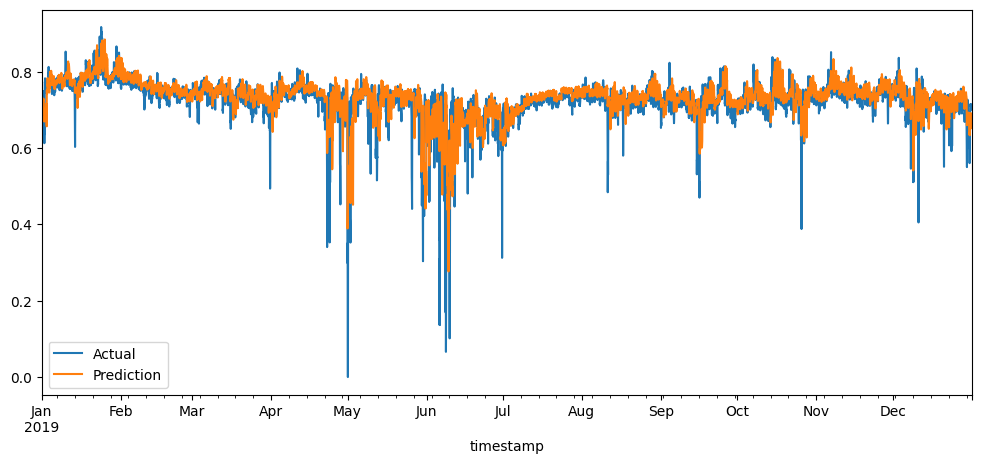

In [21]:
plt.figure(figsize=(12, 5))
test.loc[0]['vwap_log'].plot(label='Actual')
forecasts.loc[0]['mean'].plot(label='Prediction')
plt.legend()

## Zooming in on a Month

(430944.0, 431688.0)

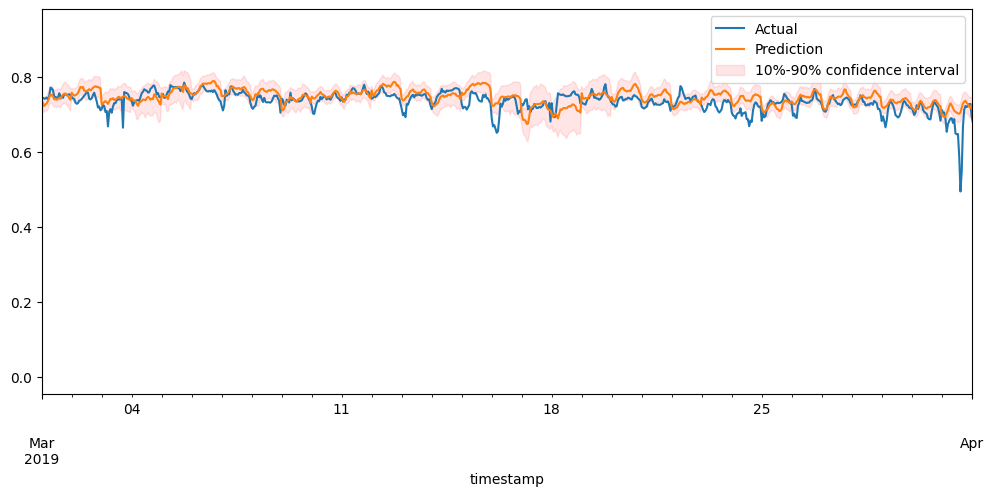

In [22]:
plt.figure(figsize=(12, 5))

y_pred = forecasts.loc[0]
y_test = test.loc[0]

y_test['vwap_log'].plot(label='Actual')
y_pred['mean'].plot(label='Prediction')

plt.fill_between(
  y_pred.index,
  y_pred["0.1"],
  y_pred["0.9"],
  color="red",
  alpha=0.1,
  label=f"10%-90% confidence interval"
)
plt.legend()

plt.xlim(
  left=y_test.index[0] + pd.DateOffset(months=2),
  right=y_test.index[0] + pd.DateOffset(months=3)
)

# Scaling Back

In [23]:
forecasts['Forecasted VWAP'] = mlog_inv(scaler.inverse_transform(forecasts['mean'].values.reshape(-1, 1)))
forecasts

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2019-01-01 00:00:00  0.690550  0.660497  0.676899  0.684782  0.688207   
        2019-01-01 01:00:00  0.688486  0.653953  0.665986  0.676931  0.682106   
        2019-01-01 02:00:00  0.685666  0.639611  0.658618  0.668000  0.676651   
        2019-01-01 03:00:00  0.690771  0.632391  0.663940  0.674617  0.681428   
        2019-01-01 04:00:00  0.695480  0.630801  0.651904  0.679347  0.689673   
...                               ...       ...       ...       ...       ...   
        2019-12-31 19:00:00  0.683908  0.617208  0.651632  0.661815  0.679030   
        2019-12-31 20:00:00  0.677284  0.626434  0.645933  0.656843  0.670581   
        2019-12-31 21:00:00  0.682271  0.633971  0.650340  0.661723  0.672925   
        2019-12-31 22:00:00  0.670306  0.605269  0.638065  0.649380  0.668615   
        2019-12-31 23:00:00  0.652479  0.578230  0.619159  0.638145  0.651060   

                                  0.5       0.6       0.7       0.8       0.9  \
item_id timestamp                                                               
0       2019-01-01 00:00:00  0.691045  0.695950  0.700736  0.711293  0.723463   
        2019-01-01 01:00:00  0.691350  0.698042  0.707178  0.718283  0.726959   
        2019-01-01 02:00:00  0.685723  0.697131  0.704779  0.713540  0.726748   
        2019-01-01 03:00:00  0.694040  0.703697  0.712120  0.720995  0.744381   
        2019-01-01 04:00:00  0.697011  0.706823  0.722511  0.732279  0.753644   
...                               ...       ...       ...       ...       ...   
        2019-12-31 19:00:00  0.698264  0.705368  0.712160  0.721354  0.731148   
        2019-12-31 20:00:00  0.687947  0.699749  0.708397  0.715501  0.726591   
        2019-12-31 21:00:00  0.681899  0.701379  0.710102  0.720550  0.732230   
        2019-12-31 22:00:00  0.676912  0.687933  0.701212  0.710037  0.721755   
        2019-12-31 23:00:00  0.662629  0.670883  0.681558  0.688596  0.715915   

                             Forecasted VWAP  
item_id timestamp                             
0       2019-01-01 00:00:00        27.539470  
        2019-01-01 01:00:00        27.111694  
        2019-01-01 02:00:00        26.537063  
        2019-01-01 03:00:00        27.585656  
        2019-01-01 04:00:00        28.585655  
...                                      ...  
        2019-12-31 19:00:00        26.184505  
        2019-12-31 20:00:00        24.893012  
        2019-12-31 21:00:00        25.859799  
        2019-12-31 22:00:00        23.594422  
        2019-12-31 23:00:00        20.544457  

[8760 rows x 11 columns]

# Predictions vs Actual Dataset

(430944.0, 431688.0)

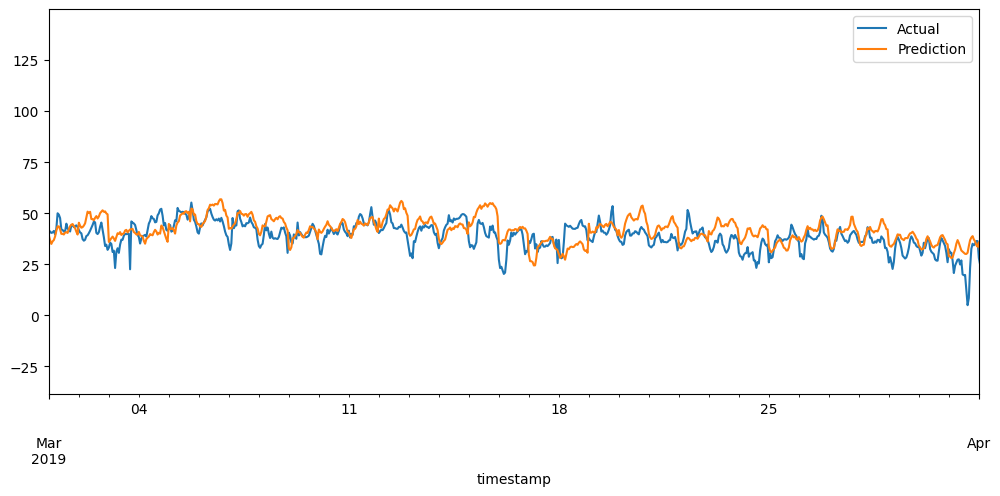

In [24]:
plt.figure(figsize=(12, 5))

actual_prices = intraday_prices(start=end_year, end_incl=end_year)
y_pred = forecasts.loc[0]

actual_prices['vwap'].plot(label='Actual')
y_pred['Forecasted VWAP'].plot(label='Prediction')

plt.legend()

plt.xlim(
  left=y_test.index[0] + pd.DateOffset(months=2),
  right=y_test.index[0] + pd.DateOffset(months=3)
)

# Evaluation
For simplicity's sake, let's use Darts to evaluate the performance, just to be consistent with other models.

In [25]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [26]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.1 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=ea4bc909f67a02bcd05ac228907a9bf5b7ceb9ac21febe06feca7ce08f9b3aa4
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [27]:
from darts.metrics.metrics import _get_values_or_raise

def wape(actual_series, pred_series):
  y_true, y_hat = _get_values_or_raise(actual_series, pred_series, intersect=True, remove_nan_union=True)
  return 100.0 * np.sum(np.abs(y_true - y_hat)) / np.sum(np.abs(y_true))

In [28]:
from darts import TimeSeries
from darts.metrics import smape, rmse

actual_ts = TimeSeries.from_dataframe(actual_prices)
prediction_ts = TimeSeries.from_series(forecasts.loc[0]['Forecasted VWAP'])

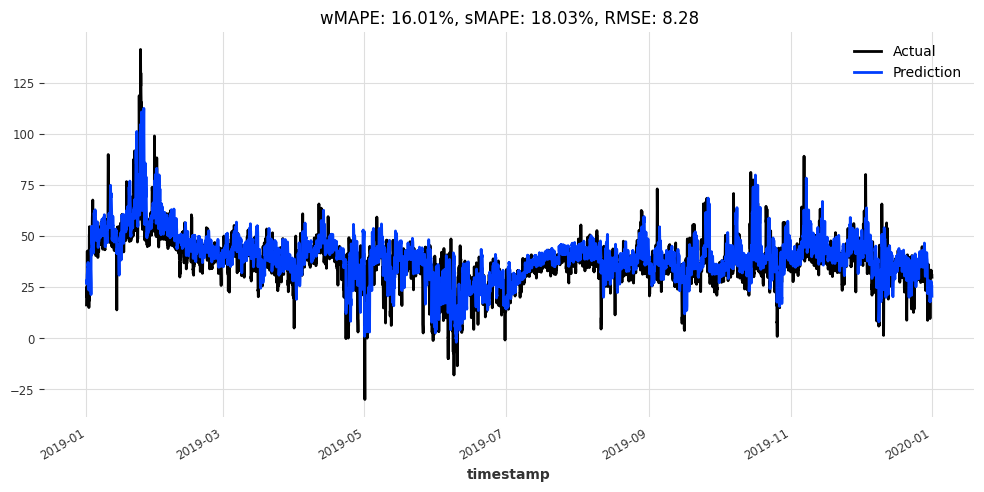

In [29]:
plt.figure(figsize=(12, 5))
actual_ts.plot(label='Actual')
prediction_ts.plot(label='Prediction')

plt.title('wMAPE: {:.2f}%, sMAPE: {:.2f}%, RMSE: {:.2f}'.format(wape(actual_ts, prediction_ts), smape(actual_ts, prediction_ts), rmse(actual_ts, prediction_ts)))
plt.legend()